# Sleep-EDF Exapnded

Source: https://www.physionet.org/content/sleep-edfx/1.0.0/

- The sleep-edf database contains 197 whole-night PolySomnoGraphic sleep recordings, containing EEG, EOG, chin EMG, and event markers
- Corresponding hypnograms (sleep patterns) were manually scored by well-trained technicians according to the Rechtschaffen and Kales manual, and are also available.

### Sleep Cassette Study and Data

- The 153 SC* files (SC = Sleep Cassette) were obtained in a 1987-1991 study of age effects on sleep in healthy Caucasians aged 25-101, without any sleep-related medication
- Two PSGs of about 20 hours each were recorded during two subsequent day-night periods at the subjects homes. Subjects continued their normal activities but wore a modified Walkman-like cassette-tape recorder
- Files are named in the form SC4**ssN**EO-PSG.edf where **ss** is the subject number, and **N** is the night. 
- The EOG and EEG signals were each sampled at 100 Hz.

### Sleep Telemetry Study and Data

- The 44 ST* files (ST = Sleep Telemetry) were obtained in a 1994 study of temazepam effects on sleep in 22 Caucasian males and females without other medication. 
- Subjects had mild difficulty falling asleep but were otherwise healthy. 
- The PSGs of about 9 hours were recorded in the hospital during two nights, one of which was after temazepam intake, and the other of which was after placebo intake.
- Files are named in the form ST7ssNJ0-PSG.edf where ss is the subject number, and N is the night.
- EOG, EMG and EEG signals were sampled at **100 Hz**, and the event marker at **1 Hz**

## Import Modules

In [1]:
import numpy as np
import pandas as pd
from pyedflib import highlevel
import matplotlib.pyplot as plt
import os
import random
import shutil
from  tqdm import tqdm

## Dataset Path

In [2]:
# path = './sleep_edf/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette'
#path = '../sleep_edf/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/'
BASE_PATH = '/home/aiot/data/physionet.org/files/sleep-edfx/1.0.0/'
path = os.path.join(BASE_PATH, 'sleep-telemetry')

## Utils for EDF file

**Search signal and its corresponding annotation**

In [3]:
def search_signals_edf(dirname): 
    '''
    find signals files (PSG.edf)
    * Input
    - dirname: file path
    '''
    filenames = os.listdir(dirname)
    filenames = [file for file in filenames if file.endswith('PSG.edf')]
    
    return filenames


def search_annotations_edf(dirname): 
    '''
    find annotations files (Hypnogram.edf)
    * Input
    - dirname: file path
    '''
    filenames = os.listdir(dirname)
    filenames = [file for file in filenames if file.endswith('Hypnogram.edf')]
    
    return filenames


def match_annotations(dirname, filename): 
    '''
    find corresponding annotation files
    * Input
    - dirname: file path
    - filename: PSG.edf file name
    '''
    match_filename = filename.split('-')[0][:-2]
    # ex> 'ST7062J0-PSG.edf' -> ST7062
    file_list = os.listdir(dirname)
    filename = [file for file in file_list if match_filename in file if file.endswith("Hypnogram.edf")]

    return filename

In [4]:
# Test
signal_files = search_signals_edf(path)
annotation_files = search_annotations_edf(path)

for filename in signal_files:
    print('signal file name : %s, annotation file name: %s' %(filename, match_annotations(path, filename)[0]) )

signal file name : ST7062J0-PSG.edf, annotation file name: ST7062JR-Hypnogram.edf
signal file name : ST7051J0-PSG.edf, annotation file name: ST7051JA-Hypnogram.edf
signal file name : ST7092J0-PSG.edf, annotation file name: ST7092JE-Hypnogram.edf
signal file name : ST7242J0-PSG.edf, annotation file name: ST7242JO-Hypnogram.edf
signal file name : ST7222J0-PSG.edf, annotation file name: ST7222JA-Hypnogram.edf
signal file name : ST7122J0-PSG.edf, annotation file name: ST7122JE-Hypnogram.edf
signal file name : ST7112J0-PSG.edf, annotation file name: ST7112JE-Hypnogram.edf
signal file name : ST7111J0-PSG.edf, annotation file name: ST7111JE-Hypnogram.edf
signal file name : ST7022J0-PSG.edf, annotation file name: ST7022JM-Hypnogram.edf
signal file name : ST7081J0-PSG.edf, annotation file name: ST7081JW-Hypnogram.edf
signal file name : ST7151J0-PSG.edf, annotation file name: ST7151JA-Hypnogram.edf
signal file name : ST7192J0-PSG.edf, annotation file name: ST7192JR-Hypnogram.edf
signal file name

## EDA (Exploratory Data Analysis): Sleep-EDF

**# read an edf file**
- signals, signal_headers, header = highlevel.read_edf('edf_file.edf')

In [5]:
# EDF file path
signal_edf_file = os.path.join(path, signal_files[1])
annotation_edf_file = os.path.join(path, match_annotations(path, signal_files[1])[0])
print(signal_edf_file)
print(annotation_edf_file)

/home/aiot/data/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/ST7051J0-PSG.edf
/home/aiot/data/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/ST7051JA-Hypnogram.edf


In [6]:
# Read EDF file
signals, signal_headers, header = highlevel.read_edf(signal_edf_file)
_, _, annotations = highlevel.read_edf(annotation_edf_file)

**# Signal_edf_file**
- signal_headers: 
    - 'label' -> 'EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker'
    - 'dimension', 'sample_rate', 'sample_frequency'...
- header:
    - psg and patient info
- annotations:
    - 'annotations': [start time, duration, event label]
        - Wake: 'Sleep stage W'
        - N1: 'Sleep stage 1'
        - N2: 'Sleep stage 2'
        - N3: 'Sleep stage 3'
        - N4: 'Sleep stage 4'
        - REM: 'Sleep stage R'

In [7]:
signal_headers[0]

{'label': 'EEG Fpz-Cz',
 'dimension': 'uV',
 'sample_rate': 1000.0,
 'sample_frequency': 1000.0,
 'physical_max': 3000.0,
 'physical_min': -3000.0,
 'digital_max': 8191,
 'digital_min': -8192,
 'prefilter': 'LP:800Hz HP:0.03Hz',
 'transducer': 'Ag-AgCl electrodes'}

* sample rate, sample frequency 오류: 1000 -> 100Hz

In [8]:
signal_order = []
for signal in signal_headers:
    signal_order.append(signal['label'])
    
signal_order

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']

In [9]:
annotations_list = annotations['annotations']

In [10]:
annotations_list

[[750.0, 90.0, 'Sleep stage 1'],
 [840.0, 60.0, 'Sleep stage W'],
 [900.0, 120.0, 'Sleep stage 1'],
 [1020.0, 60.0, 'Sleep stage W'],
 [1080.0, 120.0, 'Sleep stage 1'],
 [1200.0, 90.0, 'Sleep stage W'],
 [1290.0, 390.0, 'Sleep stage 1'],
 [1680.0, 30.0, 'Sleep stage 2'],
 [1710.0, 60.0, 'Sleep stage 1'],
 [1770.0, 30.0, 'Sleep stage 2'],
 [1800.0, 30.0, 'Sleep stage W'],
 [1830.0, 30.0, 'Sleep stage 1'],
 [1860.0, 30.0, 'Sleep stage 2'],
 [1890.0, 60.0, 'Sleep stage 1'],
 [1950.0, 60.0, 'Sleep stage W'],
 [2010.0, 120.0, 'Sleep stage 1'],
 [2130.0, 600.0, 'Sleep stage 2'],
 [2730.0, 120.0, 'Sleep stage 3'],
 [2850.0, 30.0, 'Sleep stage 2'],
 [2880.0, 30.0, 'Sleep stage 4'],
 [2910.0, 30.0, 'Sleep stage 3'],
 [2940.0, 30.0, 'Sleep stage 2'],
 [2970.0, 30.0, 'Sleep stage 4'],
 [3000.0, 30.0, 'Sleep stage 3'],
 [3030.0, 90.0, 'Sleep stage 4'],
 [3120.0, 180.0, 'Sleep stage 3'],
 [3300.0, 90.0, 'Sleep stage 4'],
 [3390.0, 60.0, 'Sleep stage 3'],
 [3450.0, 60.0, 'Sleep stage 4'],
 [3510.0, 

## Data Preprocessing

**Make signal (in 30 sec = 1 epoch) and its corresponding annotations**

In [11]:
'''
Parameters
- 1 epoch = 30 seconds
- sample frequency = 100 Hz
'''
epoch_size = 30
sample_rate = 100

'''
File path
'''
#curr_path = os.getcwd() + '/'
data_path = os.path.join('/home','aiot','data')
PROCESSED_DATA_PATH = os.path.join(data_path,'origin_npy')
save_signals_path_SC = os.path.join(PROCESSED_DATA_PATH,'signals_SC')
save_annotations_path_SC = os.path.join(PROCESSED_DATA_PATH,'annotations_SC')
save_signals_path_ST = os.path.join(PROCESSED_DATA_PATH,'signals_ST')
save_annotations_path_ST = os.path.join(PROCESSED_DATA_PATH,'annotations_ST')
# Trime the first and last epoch(30 seconds)
#save_annotations_path2 = os.path.join(PROCESSED_DATA_PATH,'annotations2')

'''
Make directory
*exist_ok = True : Make directory if there isn't directory in the path
'''
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
os.makedirs(save_signals_path_SC, exist_ok=True)
os.makedirs(save_annotations_path_SC, exist_ok=True)
os.makedirs(save_signals_path_ST, exist_ok=True)
os.makedirs(save_annotations_path_ST, exist_ok=True)
#os.makedirs(save_annotations_path2, exist_ok=True)

01. Sleep-telemetry

In [12]:
'''
EDF dataset path
'''
# signal_path = './sleep_edf/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette'
#path = '../sleep_edf/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/'
path = os.path.join(BASE_PATH, 'sleep-telemetry')
'''
Extract signals EDF files
'''
signals_edf_list = search_signals_edf(path)

In [13]:
for filename in signals_edf_list:
    
    # Signal file path & Annotation file path
    signal_path = os.path.join(path, filename)
    annotation_path = os.path.join(path, match_annotations(path,filename)[0])

    
    # Read signal
    signals, signal_headers, header = highlevel.read_edf(signal_path)
    signal_len = len(signals[0]) // sample_rate // epoch_size 
    
    # Read annotation: find labels for epochs
    try:
        _, _, annotations = highlevel.read_edf(annotation_path)
    except Exception as e:
        print(str(e))
        continue

    label = []
    for ann in annotations['annotations']:
        '''
        annotations['annotations'] = [[start_time, duration, event_label], ...]
        W(0): Sleep stage W
        N1(1): Sleep stage 1
        N2(2): Sleep stage 2
        N3(3): Sleep stage 3 & 4
        REM(4): Sleep stage R
        Unknown(5)
        '''
        start_time = ann[0]
        
        duration = ann[1] # duration in seconds
        duration = int(duration) // epoch_size # duration in epoch
        
        event_label = ann[2]

        if event_label == 'Sleep stage W':
            for event in range(duration):
                label.append(0)
        elif event_label == 'Sleep stage 1':
            for event in range(duration):
                label.append(1)
        elif event_label == 'Sleep stage 2':
            for event in range(duration):
                label.append(2)
        elif event_label == 'Sleep stage 3' or event_label == 'Sleep stage 4':
            for event in range(duration):
                label.append(3)
        elif event_label == 'Sleep stage R':
            for event in range(duration):
                label.append(4)
        else:
            for event in range(duration):
                label.append(5)
                
    label = np.array(label)
    annotations_len = len(label)
    
    
    # Cut off the signal data at the length of the sleep stage labels (annotation)
    # Select 'Fpz-Cz' only (singals[0])
    if header['startdate'] == annotations['startdate']:
        print("%s file's signal & annotations start time is same"%signal_path.split('/')[-1])

        if signal_len > annotations_len :
            signals = signals[0][:(epoch_size * sample_rate * annotations_len)]
        else: # signal_len < annotations_len
            signals = signals[0][:(epoch_size * sample_rate * signal_len)]
            label = label[:signal_len]

        signals = np.array(signals)
        signals = signals.reshape(-1,epoch_size * sample_rate)
        
        # Save npy file
        np.save(os.path.join(save_signals_path_ST, signal_path.split('/')[-1].split('.')[0]),signals)
        np.save(os.path.join(save_annotations_path_ST, annotation_path.split('/')[-1].split('.')[0]),label)
        #np.save(os.path.join(save_annotations_path2, annotation_path.split('/')[-1].split('.')[0]),label[1:-1])

        #if (len(signals) // (epoch_size * sample_rate) != len(label)):
        if (len(signals) != len(label)):
            print('signals len : %d / annotations len : %d'%(len(signals),len(label)))
            #print('signals len : %d / annotations len : %d'%(len(signals) // (epoch_size * sample_rate),len(label)))

    else:
        print("%s file''s signal & annotations start time is different"%signal_path.split('/')[-1])

ST7062J0-PSG.edf file's signal & annotations start time is same
signals len : 0 / annotations len : 952
ST7051J0-PSG.edf file's signal & annotations start time is same
signals len : 0 / annotations len : 1018
/home/aiot/data/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/ST7092JE-Hypnogram.edf: the file is not EDF(+) or BDF(+) compliant (EDF+ Recordingfield)
ST7242J0-PSG.edf file's signal & annotations start time is same
signals len : 0 / annotations len : 940
ST7222J0-PSG.edf file's signal & annotations start time is same
signals len : 0 / annotations len : 951
ST7122J0-PSG.edf file's signal & annotations start time is same
signals len : 0 / annotations len : 969
ST7112J0-PSG.edf file's signal & annotations start time is same
signals len : 0 / annotations len : 986
ST7111J0-PSG.edf file's signal & annotations start time is same
signals len : 0 / annotations len : 1023
ST7022J0-PSG.edf file's signal & annotations start time is same
signals len : 0 / annotations len : 944
ST7081J0

2. Sleep-cassette

In [13]:
'''
EDF dataset path
'''
# signal_path = './sleep_edf/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette'
# path = '../sleep_edf/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/'
path = os.path.join(BASE_PATH, 'sleep-cassette')

'''
Extract signals EDF files
'''
signals_edf_list = search_signals_edf(path)

In [19]:
for filename in signals_edf_list:
    
    # Signal file path & Annotation file path
    signal_path = os.path.join(path, filename)
    annotation_path = os.path.join(path, match_annotations(path,filename)[0])

    
    # Read signal
    signals, signal_headers, header = highlevel.read_edf(signal_path)
    signal_len = len(signals[0]) // sample_rate // epoch_size 
    
    
    # Read annotation: find labels for epochs
    try:
        _, _, annotations = highlevel.read_edf(annotation_path)
    except Exception as e:
        print(str(e))
        continue

    label = []
    for ann in annotations['annotations']:
        '''
        annotations['annotations'] = [[start_time, duration, event_label], ...]
        W(0): Sleep stage W
        N1(1): Sleep stage 1
        N2(2): Sleep stage 2
        N3(3): Sleep stage 3 & 4
        REM(4): Sleep stage R
        Unknown(5)
        '''
        start_time = ann[0]
        
        duration = ann[1] # duration in seconds
        duration = int(duration) // epoch_size # duration in epoch
        
        event_label = ann[2]

        if event_label == 'Sleep stage W':
            for event in range(duration):
                label.append(0)
        elif event_label == 'Sleep stage 1':
            for event in range(duration):
                label.append(1)
        elif event_label == 'Sleep stage 2':
            for event in range(duration):
                label.append(2)
        elif event_label == 'Sleep stage 3' or event_label == 'Sleep stage 4':
            for event in range(duration):
                label.append(3)
        elif event_label == 'Sleep stage R':
            for event in range(duration):
                label.append(4)
        else:
            for event in range(duration):
                label.append(5)
                
    label = np.array(label)
    annotations_len = len(label)
    
    
    # Cut off the signal data at the length of the sleep stage labels (annotation)
    # Select 'Fpz-Cz' only
    if header['startdate'] == annotations['startdate']:
        print("%s file's signal & annotations start time is same"%signal_path.split('/')[-1])

        if signal_len > annotations_len :
            signals = signals[0][:(epoch_size * sample_rate * annotations_len)]
        else: # signal_len < annotations_len
            signals = signals[0][:epoch_size * sample_rate * signal_len]
            label = label[:signal_len]

        signals = np.array(signals)
        signals = signals.reshape(-1,epoch_size * sample_rate)
        
    # Save npy file

        np.save(os.path.join(save_signals_path_SC,signal_path.split('/')[-1].split('.')[0]),signals)
        np.save(os.path.join(save_annotations_path_SC, annotation_path.split('/')[-1].split('.')[0]),label)
        #np.save(os.path.join(save_annotations_path2, annotation_path.split('/')[-1].split('.')[0]),label[1:-1])

        #if (len(signals) // (epoch_size * sample_rate) != len(label)):
        if (len(signals) != len(label)):
            print('signals len : %d / annotations len : %d'%(len(signals),len(label)))
            #print('signals len : %d / annotations len : %d'%(len(signals) // (epoch_size * sample_rate),len(label)))


    else:
        print("%s file''s signal & annotations start time is different"%signal_path.split('/')[-1])

SC4092E0-PSG.edf file's signal & annotations start time is same
SC4112E0-PSG.edf file's signal & annotations start time is same
SC4512E0-PSG.edf file's signal & annotations start time is same
SC4771G0-PSG.edf file's signal & annotations start time is same
SC4252E0-PSG.edf file's signal & annotations start time is same
SC4271F0-PSG.edf file's signal & annotations start time is same
SC4732E0-PSG.edf file's signal & annotations start time is same
SC4502E0-PSG.edf file's signal & annotations start time is same
SC4601E0-PSG.edf file's signal & annotations start time is same
SC4212E0-PSG.edf file's signal & annotations start time is same
SC4461F0-PSG.edf file's signal & annotations start time is same
SC4711E0-PSG.edf file's signal & annotations start time is same
SC4012E0-PSG.edf file's signal & annotations start time is same
SC4311E0-PSG.edf file's signal & annotations start time is same
SC4472F0-PSG.edf file's signal & annotations start time is same
SC4332F0-PSG.edf file's signal & annotat

SC4022E0-PSG.edf file's signal & annotations start time is same
SC4632E0-PSG.edf file's signal & annotations start time is same
SC4282G0-PSG.edf file's signal & annotations start time is same
SC4071E0-PSG.edf file's signal & annotations start time is same
SC4481F0-PSG.edf file's signal & annotations start time is same
SC4462F0-PSG.edf file's signal & annotations start time is same
SC4652E0-PSG.edf file's signal & annotations start time is same
SC4181E0-PSG.edf file's signal & annotations start time is same
SC4192E0-PSG.edf file's signal & annotations start time is same
SC4301E0-PSG.edf file's signal & annotations start time is same
SC4321E0-PSG.edf file's signal & annotations start time is same
SC4811G0-PSG.edf file's signal & annotations start time is same
SC4341F0-PSG.edf file's signal & annotations start time is same
SC4001E0-PSG.edf file's signal & annotations start time is same
SC4312E0-PSG.edf file's signal & annotations start time is same
SC4002E0-PSG.edf file's signal & annotat

## Utils for npy file

In [14]:
def search_signals_npy(dirname):
    filenames = os.listdir(dirname)
    filenames = [file for file in filenames if file.endswith('.npy')]
    
    return filenames

def match_annotations_npy(dirname, filename):
    search_filename = filename.split('-')[0][:-2]
    file_list = os.listdir(dirname)
    filenames = [file for file in file_list if search_filename in file if file.endswith('.npy')]

    return filenames

In [15]:
npy_signals_ST = search_signals_npy(save_signals_path_ST)
npy_signals_SC = search_signals_npy(save_signals_path_SC)

Test

In [16]:
signal_file = npy_signals_ST[8]
ann_file = match_annotations_npy(save_annotations_path_ST, signal_file)
print('signal : ' , signal_file)
print('annotation : ', ann_file[0])

signal :  ST7242J0-PSG.npy
annotation :  ST7242JO-Hypnogram.npy


In [17]:
signal_npy = np.load(os.path.join(save_signals_path_ST, signal_file))

In [18]:
anns = np.load(os.path.join(save_annotations_path_ST, ann_file[0]))

In [19]:
len(signal_npy)

940

In [20]:
len(anns)

940

In [21]:
signal_npy.shape

(940, 3000)

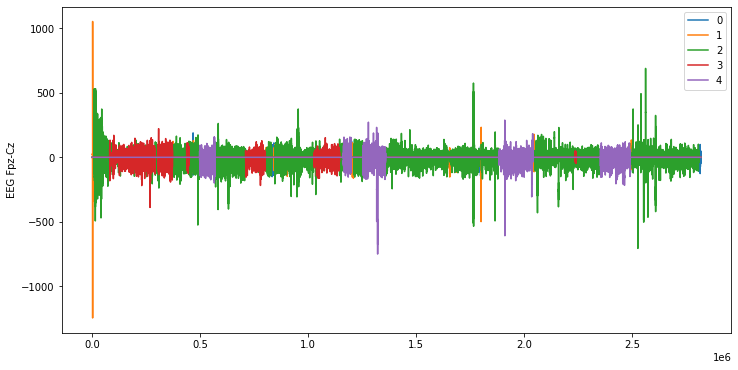

In [22]:
fig, ax = plt.subplots(figsize=(12,6))

singal_npy_reshape = signal_npy.reshape(-1, 3000)
t = np.array([i for i in range(len(signal_npy.reshape(-1)))])
for cls in range(5):        
    cls_filter = np.expand_dims(np.where(anns==cls,1,0), axis=-1) * singal_npy_reshape
    plt.plot(t, cls_filter.reshape(-1), label=cls)
    plt.legend()

#plt.plot(t, signal_npy.reshape(-1))
plt.ylabel('EEG Fpz-Cz')
plt.show()

Text(0, 0.5, 'EEG Fpz-Cz')

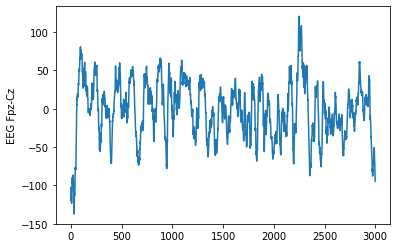

In [23]:
plt.plot(signal_npy[300])
plt.ylabel('EEG Fpz-Cz')

In [36]:
from scipy import signal
from scipy.signal import butter, lfilter, sosfilt

In [42]:
# Filtering functions: Butterworth bandpass filter
# Notch filter(band stop filter)
def butter_bandpass(lowcut, highcut, fs, order=8):
    #nyq = 0.5 * fs
    #low = lowcut / nyq
    #high = highcut / nyq
    #b, a = butter(order, [low, high], btype='band')
    low = lowcut
    high = highcut
    sos  = butter(order, [low, high], btype='band', fs=fs, output='sos', analog=False)
    return sos 

def butter_bandpass_filter(data, lowcut, highcut, fs, order=8):
    sos  = butter_bandpass(lowcut, highcut, fs, order=order)
    #y = lfilter(b, a, data)
    y = sosfilt(sos, data)
    return y

# Filtering functions: Butterworth bandpass filter
# Notch filter(band stop filter)
def butter_bandpass_orig(lowcut, highcut, fs, order=8):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    
    return b, a

def butter_bandpass_filter_orig(data, lowcut, highcut, fs, order=8):
    b,a  = butter_bandpass_orig(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)    
    return y

def notch_filter(data, f0, Q, fs):
    b, a = signal.iirnotch(f0, Q, fs)
    y = lfilter(b, a, data)
    return y

In [26]:
save_filtered_signals_path_ST = os.path.join(PROCESSED_DATA_PATH,'signals_ST_filtered')
save_filtered_signals_path_SC = os.path.join(PROCESSED_DATA_PATH,'signals_SC_filtered')
os.makedirs(save_filtered_signals_path_ST, exist_ok=True)
os.makedirs(save_filtered_signals_path_SC, exist_ok=True)

In [57]:
def filter_signal(file_list, in_folder, output_folder):
    for signal_file in tqdm(file_list):
        data = np.load(os.path.join(in_folder, signal_file))
        fs = 100 #Sample rate, in Hz
        seconds = 30
        num_samples = fs * seconds

        # Filter out too small or large amplitude
        #data_limit = np.minimum(np.maximum(data, -150), 150)

        #data_reshape = data.reshape((-1,num_sample))
        filtered_signal = []
        for i in range(len(data)):
            single_epoch = data[i]

            # Notch filter to cancel out the power line disturbance
            f0, Q = 50, 30
            y1 = notch_filter(single_epoch, f0, Q, fs)
            #f0 = 60
            #y2 = notch_filter(y1, f0, Q, fs)

            # Butterworth filter for valid freq signals
            low, high = 0.3, 35 
            filtered_epoch = butter_bandpass_filter(y1, low, high, fs)
            
            ### NOrmalize...
            from sklearn.preprocessing import scale
            filtered_epoch = scale(filtered_epoch)
            
            filtered_signal.append(filtered_epoch)

        filtered_signal = np.array(filtered_signal)

        np.save(os.path.join(output_folder, signal_file), filtered_signal)

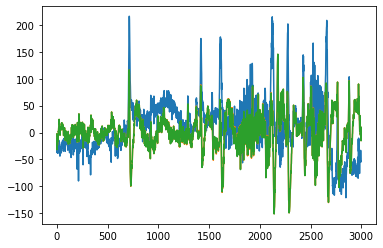

In [58]:
np_data = np.load(os.path.join(save_signals_path_ST, npy_signals_ST[0])) 
epoch1 = np_data[3]
plt.plot(epoch1)
filtered = butter_bandpass_filter(epoch1, 0.3, 35, 100)
plt.plot(filtered)

filtered_orig = butter_bandpass_filter_orig(epoch1, 0.3, 35, 100)
plt.plot(filtered_orig)

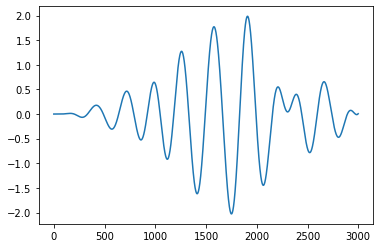

In [59]:
plt.plot(filtered_orig - filtered)

In [60]:
filter_signal(npy_signals_SC, save_signals_path_SC, save_filtered_signals_path_SC)
filter_signal(npy_signals_ST, save_signals_path_ST, save_filtered_signals_path_ST)

100%|██████████| 37/37 [01:11<00:00,  1.93s/it]


## Hilbert-Huang Transformation

- Ref1. https://pypi.org/project/emd/
- Ref2. https://pyemd.readthedocs.io/en/latest/intro.html

In [26]:
from scipy import signal, ndimage
import emd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [40]:
def ht_transform(data, visualize=False):
    '''
    data = signals.reshape(3000)[e]
    e: e th epoch
    i: i th file in npy_signals
    '''
    fs = 100 #Sample rate, in Hz
    seconds = 30
    num_samples = fs * seconds
    
    # Notch filter to cancel out the power line disturbance
    f0, Q = 50, 30
    y1 = notch_filter(data, f0, Q, fs)
    #f0 = 60
    #y2 = notch_filter(y1, f0, Q, fs)

    # Butterworth filter for valid freq signals
    low, high = 0.3, 35 
    filtered_epoch = butter_bandpass_filter(y1, low, high, fs)
    
    # Estimate IMFs    
    #imf = imf[fs * seconds:-fs * seconds]
    imf = emd.sift.sift(filtered_epoch)

    # Compute instantaneous phase, frequency and amplitude using the Normalised Hilbert Transform Method
    IP, IF, IA = emd.spectra.frequency_transform(imf, fs, 'hilbert')
    
    #IA = np.log(IA+1)

    # Compute Hilbert-Huang spectrum
    freq_range = (0.3, 35, 35)    
    """
    imf = emd.sift.sift(filtered_signal, max_imfs=5)
    for i in range(5):
        hht_f, hht = emd.spectra.hilberthuang(IF[:,i,None], IA[:,i,None], freq_range, mode='amplitude', sum_time=False)
        if i == 0:
            hht_stack = np.expand_dims(hht, -1)
        else:
            hht_stack = np.concatenate((hht_stack, np.expand_dims(hht, -1)), -1)
    """     
    
    
    hht_f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, mode='amplitude', sum_time=False)
    # Gaussian filter: 각 픽셀을 중심으로 주변 Pixel들을 Weighted average하여 픽셀 값 계산.
    #                  이때 Weight는 Gaussian 분포를 이루도록 설정
    #                  Noise 제거, Blur 효과를 주기 위해 사용
    #hht = ndimage.gaussian_filter(hht, 1)        
    
    ### NOrmalize...
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    hht_scaled = scaler.fit_transform(hht.reshape(35*3000,1))
    hht_scaled = hht_scaled.reshape(35,3000)

    if visualize:
        time_vect = np.linspace(0, hht.shape[-1] / fs, hht.shape[-1])
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(time_vect, hht_f, hht, cmap='viridis')
        plt.ylim(0, 35)
        plt.title('Hilbert-Huang Transform')
        plt.xlim(1, hht.shape[-1] / fs)
        plt.show()
    
    return hht_scaled, hht_f, IP, IF, IA

## Save Hilbert transformed data as 2D array


In [41]:
HT2D_ST_path = os.path.join(PROCESSED_DATA_PATH, 'HT2D_ST')
os.makedirs(HT2D_ST_path, exist_ok=True)

In [44]:
def read_csv_to_list(filepath):
    import csv
    with open(filepath, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        list_filepath = [row[0] for row in spamreader]
    return list_filepath

In [45]:
SC_train = os.path.join('/home','aiot','data','origin_npy','SC_train.csv')
SC_test = os.path.join('/home','aiot','data','origin_npy','SC_test.csv')

list_files_train = read_csv_to_list(SC_train)
list_files_test = read_csv_to_list(SC_test)

list_files_train = [f + '.npy' for f in list_files_train]
list_files_test = [f + '.npy' for f in list_files_test]

npy_signals = list_files_train + list_files_test

In [47]:
for signal_file in tqdm(npy_signals):
    signal_data = np.load(os.path.join(save_signals_path_SC, signal_file))
    #signal_data = signal_data.reshape(-1,epoch_size * sample_rate)
    ht_signal_arr = []
    for signal_epoch in signal_data:
        ht_signal_data, ht_signal_data_f, IP, IF, IA = ht_transform(signal_epoch)   
        #print(ht_signal_data.shape) #(35, 3000)
        #if do_normalize:
        #    normalizer = np.max(ht_signal_data) - np.min(ht_signal_data)
        #    #normalizer = np.expand_dims(normalizer, axis=1)
        #    #print(normalizer.shape)
        #    ht_signal_data = (ht_signal_data - np.min(ht_signal_data)) / (normalizer + 1e-8)  
        ht_signal_data = ht_signal_data.transpose()
        ht_signal_arr.append(ht_signal_data)
    #ht_signal_data = ht_signal_data.reshape(-1, epoch_size * sample_rate, nbins)
    ht_signal_arr = np.array(ht_signal_arr)
    np.save(os.path.join(HT2D_ST_path, (signal_file.split('.')[0] + '_HT2D')), ht_signal_arr)
    

100%|██████████| 39/39 [56:45<00:00, 87.32s/it]


In [118]:
def ht_transform_2(data, visualize=False):
    '''
    data = signals.reshape(3000)[e]
    e: e th epoch
    i: i th file in npy_signals
    '''
    fs = 100 #Sample rate, in Hz
    seconds = 30
    num_samples = fs * seconds    
    
    # Estimate IMFs
    imf = emd.sift.sift(data, max_imfs=5)
    #imf = imf[fs * seconds:-fs * seconds]

    # Compute instantaneous phase, frequency and amplitude using the Normalised Hilbert Transform Method
    IP, IF, IA = emd.spectra.frequency_transform(imf, fs, 'hilbert')
    
    IF_filtered = (IF > 0.3) * (IF < 35) * IF
    IA_filtered = (IF > 0.3) * (IF < 35) * IA
    
    hht = np.stack((IF_filtered,IA_filtered), axis=-1)
    
    return hht, IP, IF, IA

In [119]:
HT1D_ST_path = os.path.join(PROCESSED_DATA_PATH, 'HT1D_ST')
os.makedirs(HT1D_ST_path, exist_ok=True)

In [120]:
for signal_file in tqdm(npy_signals):    
    signal_data = np.load(os.path.join(save_signals_path_ST, signal_file))    
    ht_signal_data, IP, IF, IA = ht_transform_2(signal_data)           
    ht_signal_data = ht_signal_data.reshape(-1, epoch_size * sample_rate, 5, 2)
    np.save(os.path.join(HT1D_ST_path, (signal_file.split('.')[0] + '_HT1D')), ht_signal_data)

100%|██████████| 37/37 [12:12<00:00, 19.79s/it]


## Visualization

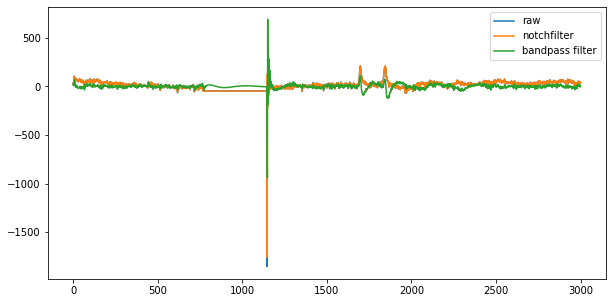

In [86]:
signal_file = npy_signals[0]
data = np.load(os.path.join(save_signals_path_ST, signal_file))
fs = 100 #Sample rate, in Hz
seconds = 30
num_samples = fs * seconds

# Filter out too small or large amplitude
#data_limit = np.minimum(np.maximum(data, -150), 150)

# Notch filter to cancel out the power line disturbance
f0, Q = 50, 30
y1 = notch_filter(data, f0, Q, fs)
#f0 = 60
#y2 = notch_filter(y1, f0, Q, fs)

# Butterworth filter for valid freq signals
low, high = 0.3, 35 
filtered_signal = butter_bandpass_filter(y1, low, high, fs)  
i = 1
plt.figure(figsize=(10,5))
plt.plot(data[3000*i:3000*(i+1)], label='raw')
plt.plot(y1[3000*i:3000*(i+1)], label='notchfilter')
plt.plot(filtered_signal[3000*i:3000*(i+1)], label='bandpass filter')
plt.legend()

2


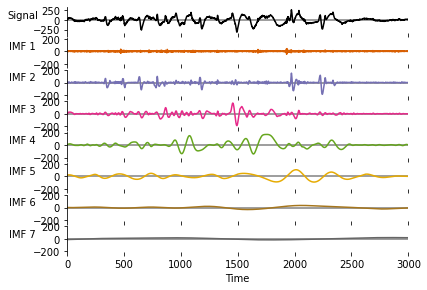

In [71]:
data_file = npy_signals_filtered[0]
signal_data = np.load(os.path.join(save_filtered_signals_path_ST, data_file))
ann_file = match_annotations_npy(save_annotations_path_ST, data_file)
ann = np.load(os.path.join(save_annotations_path_ST, ann_file[0]))
i = 9
data = signal_data[3000*i:3000*(i+1)]
label = ann[i]

fs = 100 #Sample rate, in Hz
seconds = 30
num_samples = fs * seconds

# Estimate IMFs    
#imf = imf[fs * seconds:-fs * seconds]
imf = emd.sift.sift(data)
print(label)
emd.plotting.plot_imfs(imf, cmap=True, scale_y=True)

1


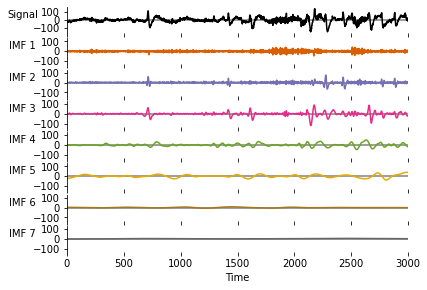

In [76]:
data_file = npy_signals_filtered[0]
signal_data = np.load(os.path.join(save_filtered_signals_path_ST, data_file))
ann_file = match_annotations_npy(save_annotations_path_ST, data_file)
ann = np.load(os.path.join(save_annotations_path_ST, ann_file[0]))
i = 3
data = signal_data[3000*i:3000*(i+1)]
label = ann[i]

fs = 100 #Sample rate, in Hz
seconds = 30
num_samples = fs * seconds

# Estimate IMFs    
#imf = imf[fs * seconds:-fs * seconds]
imf = emd.sift.sift(data)
print(label)
emd.plotting.plot_imfs(imf, cmap=True, scale_y=True)

In [72]:
IP, IF, IA = emd.spectra.frequency_transform(imf, fs, 'hilbert')

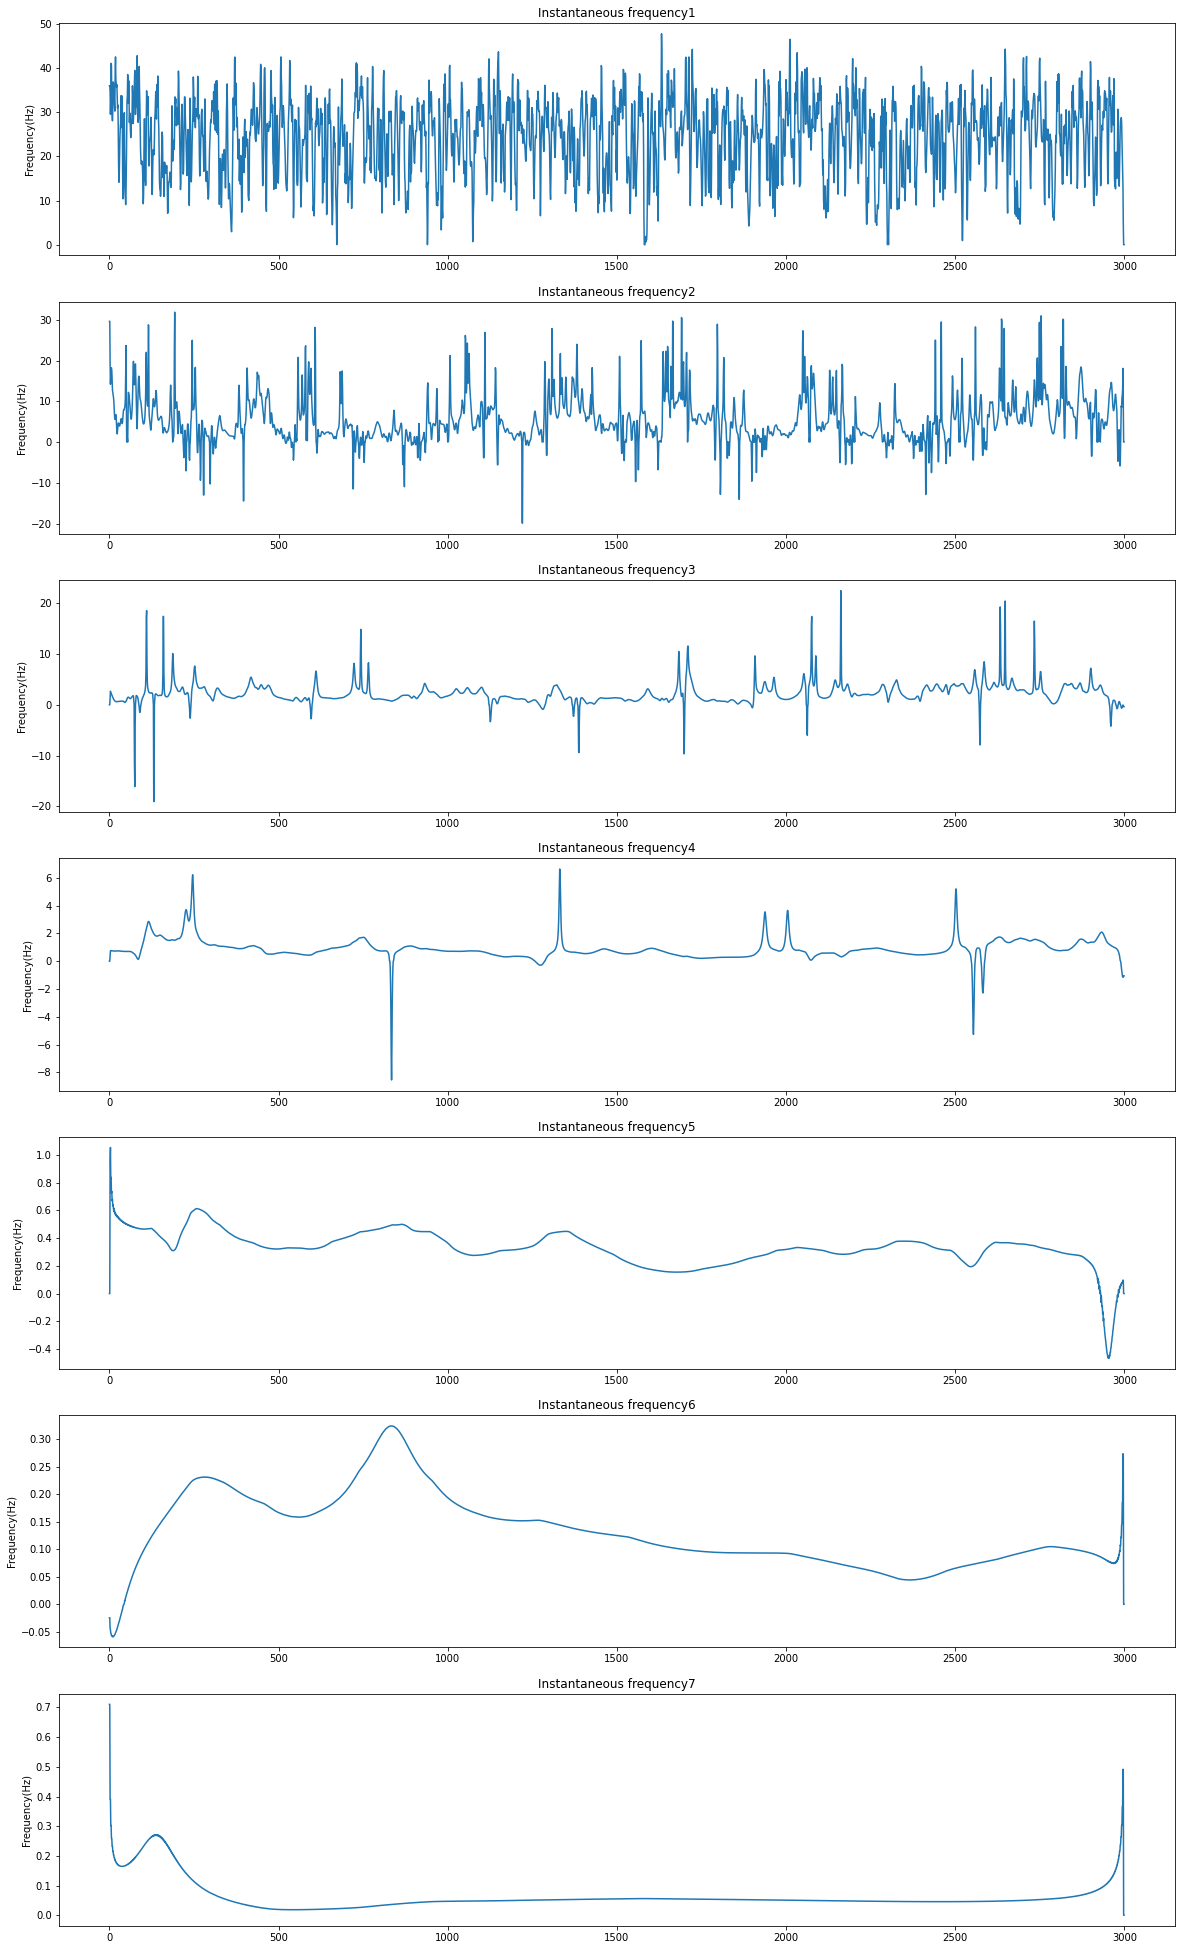

In [73]:
plt.figure(figsize=(20, 35))    
for i in range(IF.shape[1]):
    plt.subplot(710 + (i+1))    
    plt.plot(IF[:,i])
    plt.ylabel('Frequency(Hz)')
    plt.title('Instantaneous frequency' + str(i+1))

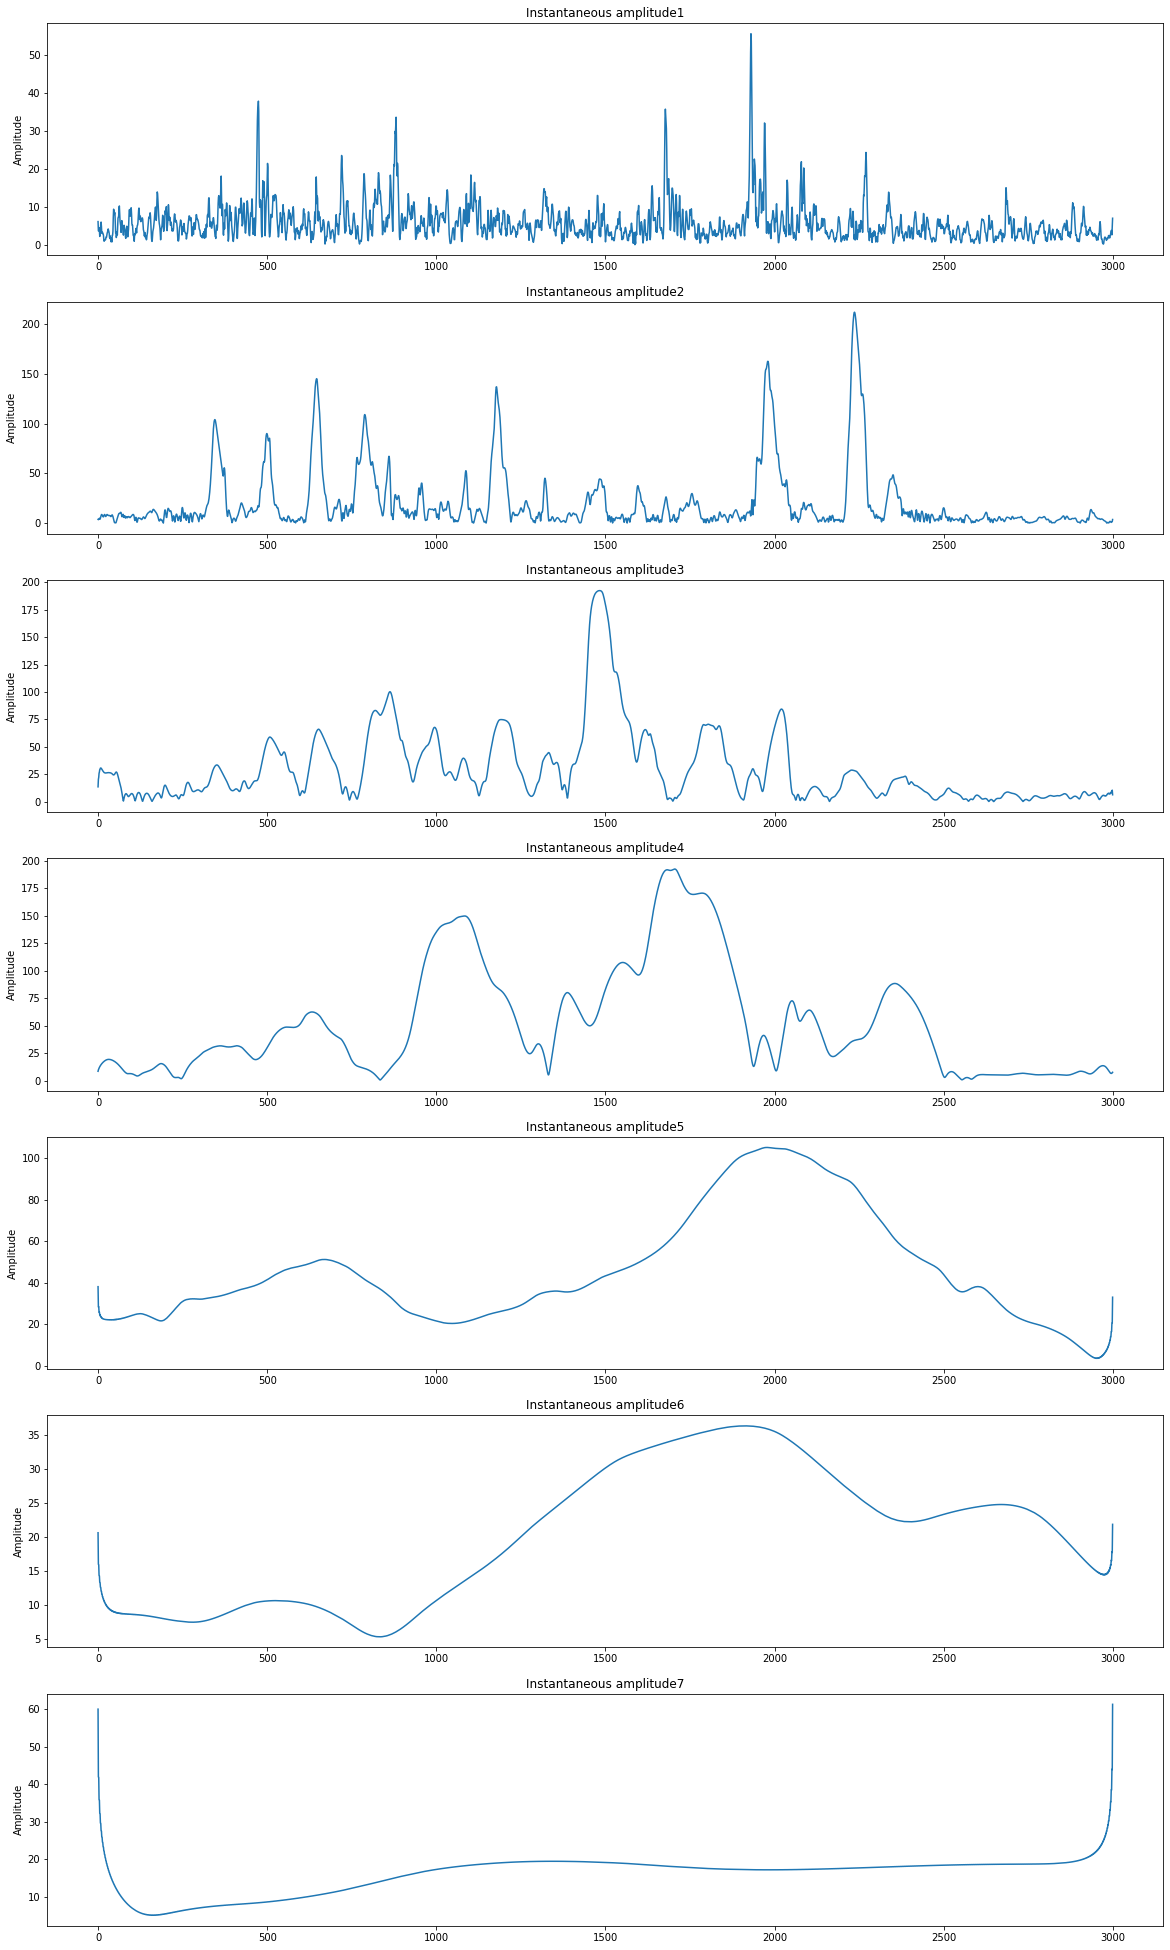

In [74]:
plt.figure(figsize=(20, 35))    
for i in range(IA.shape[1]):
    plt.subplot(710 + (i+1))    
    plt.plot(IA[:,i])
    plt.ylabel('Amplitude')
    plt.title('Instantaneous amplitude' + str(i+1))

In [58]:
 # Notch filter to cancel out the power line disturbance
fs = 100
f0, Q = 50, 30
y1 = notch_filter(signal_data, f0, Q, fs)
#f0 = 60
#y2 = notch_filter(y1, f0, Q, fs)

# Butterworth filter for valid freq signals
low, high = 0.3, 35 
filtered_signal = butter_bandpass_filter(y1, low, high, fs)   


# Estimate IMFs
imf = emd.sift.sift(filtered_signal, max_imfs=5)
imf = imf[3000:-3000]

# Compute instantaneous phase, frequency and amplitude using the Normalised Hilbert Transform Method
IP, IF, IA = emd.spectra.frequency_transform(imf, fs, 'hilbert')

"""
from scipy.signal import hilbert, chirp
analytic_signal = hilbert(imf, axis=0)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase, axis=0) /
                           (2.0*np.pi) * fs)
"""

# Compute Hilbert-Huang spectrum
freq_range = (0.01, 35, 35)

for i in range(5):
    hht_f, hht = emd.spectra.hilberthuang(IF[:,i,None], IA[:,i,None], freq_range, mode='amplitude', sum_time=False)
    # Gaussian filter: 각 픽셀을 중심으로 주변 Pixel들을 Weighted average하여 픽셀 값 계산.
    #                  이때 Weight는 Gaussian 분포를 이루도록 설정
    #                  Noise 제거, Blur 효과를 주기 위해 사용
    #hht = ndimage.gaussian_filter(hht, 1)    
    if i == 0:
        hht_stack = np.expand_dims(hht, -1)
    else:
        hht_stack = np.concatenate((hht_stack, np.expand_dims(hht, -1)), -1)


In [74]:
IF_filtered = (IF > 0.3) * (IF < 35) * IF
IA_filtered = (IF > 0.3) * (IF < 35) * IA

In [38]:
pip install sklearn

     |████████████████████████████████| 26.7 MB 19.4 MB/s eta 0:00:01    |█████████████████████▍          | 17.9 MB 9.5 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=c497a502426cd14283b286895d41c2d39fa9bbcb421450f5c59c86ae899bad22
  Stored in directory: /home/keondopark/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [39]:
from sklearn.preprocessing import StandardScaler

In [68]:
data = [[0, 1, 2], [1,2,3], [3,4,5], [5,6,7]]
scaler = StandardScaler()
scaler.fit_transform(data)

array([[-1.1717002 , -1.1717002 , -1.1717002 ],
       [-0.65094455, -0.65094455, -0.65094455],
       [ 0.39056673,  0.39056673,  0.39056673],
       [ 1.43207802,  1.43207802,  1.43207802]])

In [69]:
from sklearn.preprocessing import scale

In [71]:
scale(data, axis=1)

array([[-1.22474487,  0.        ,  1.22474487],
       [-1.22474487,  0.        ,  1.22474487],
       [-1.22474487,  0.        ,  1.22474487],
       [-1.22474487,  0.        ,  1.22474487]])

In [49]:
score = np.array([0.5, 0.3, 0.4, 0.9])

In [65]:
I = np.argsort(score)
thr = 0.4
under_thresh = np.where(score[I]<=thr)[0][-1]

In [66]:
under_thresh

1

In [67]:
I[ss:]

array([2, 0, 3])